# Charts and diagrams

In this notebook, we will show you how to draw basic financia charts.

We will

* Download daily candle data for all pairs

* Extract data for ETH-USDC pair on Uniswap v2

* Draw standard basic price charts like OHLC and OHLCV

* Plot charts as static images using [mplfinance](https://pypi.org/project/mplfinance/)

## Setup

First let's install Capitalgram package, the package dependencies and initialise our dataset client.
This might take 5 minutes in a fresh environment.

In [1]:
try:
    import capitalgram
except ImportError:
    !pip install -e git+https://github.com/miohtama/capitalgram-onchain-dex-quant-data.git#egg=capitalgram
    import site
    site.main()

from capitalgram.client import Capitalgram

client = Capitalgram.create_jupyter_client()

Started Capitalgram in Jupyter notebook environment, configuration is stored in /Users/mikkoohtamaa/.capitalgram


## Fetch data

Let's download 1 day (24h) candles to all trading pairs. This dataset is several dozens of megabytes.
You should see a progress bar during the download.

**Note**: We could also query live candle datasets for trading pairs we are interested in.
However, the bundled dataset is faster for the future analysis, as after the download
it will have all candles cached in your local notebook environment.

In [2]:
from capitalgram.timebucket import TimeBucket

# Download all 24h candles as Parquet columnar data
all_candles = client.fetch_all_candles(TimeBucket.d1)

Let's pick one pair, ETH-USDC on Uniswap v2, from the dataset to analyse.

In [3]:
import pandas as pd

# Convert PyArrow table to Pandas format to continue working on it
all_candles_dataframe = all_candles.to_pandas()

# To shorten this notebook, we know by hearth that USDC-ETH Uniswap v2 is the pair id numero uno,
# because that what Hayden used to test the production code when he deployed Uniswap v2
pair_id = 1

eth_usdc_pair: pd.DataFrame = all_candles_dataframe.loc[all_candles_dataframe['pair_id'] == pair_id]

print(f"Uniswap v2 ETH-USDC has {len(eth_usdc_pair)} daily candles")


Uniswap v2 ETH-USDC has 454 daily candles


## Static charts with mplfinance

[mplfinance](https://pypi.org/project/mplfinance/) is a Jupyter Notebook library for financial charts.
It creates static charts out from Pandas data.

Pros

* Static chart images can be saved with notebook and are displayed e.g. on Github and the documentation website

Cons

* There is no interactive explorer controls like dragging timeline or zooming in.

Below we create a simple static chart from ETH-USDC price.

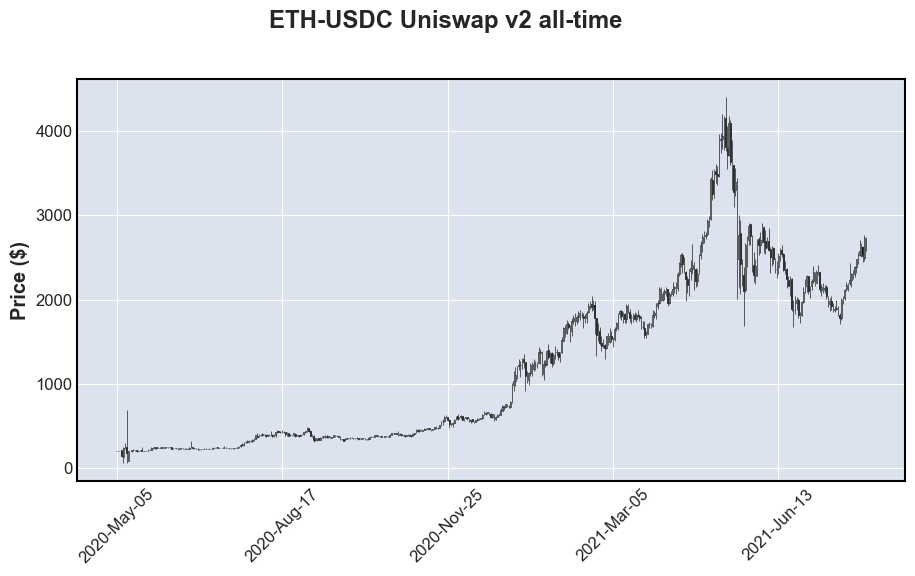

In [4]:
import mplfinance as fplt

# Add a time based index to data series, as needed by mplfinance,
# so it knows which column is the x axis
eth_usdc_pair = eth_usdc_pair.set_index(pd.DatetimeIndex(eth_usdc_pair["timestamp"]))

fplt.plot(
            eth_usdc_pair,
            type='candle',
            title='ETH-USDC Uniswap v2 all-time',
            ylabel='Price ($)',
            figratio=(20, 10)  # Setting chart ratio makes us to use more horizontal space
        )

As the daily candles are not that readable due to scale of the diagram, let's zoom in to October 2020, a randomly chosen month.

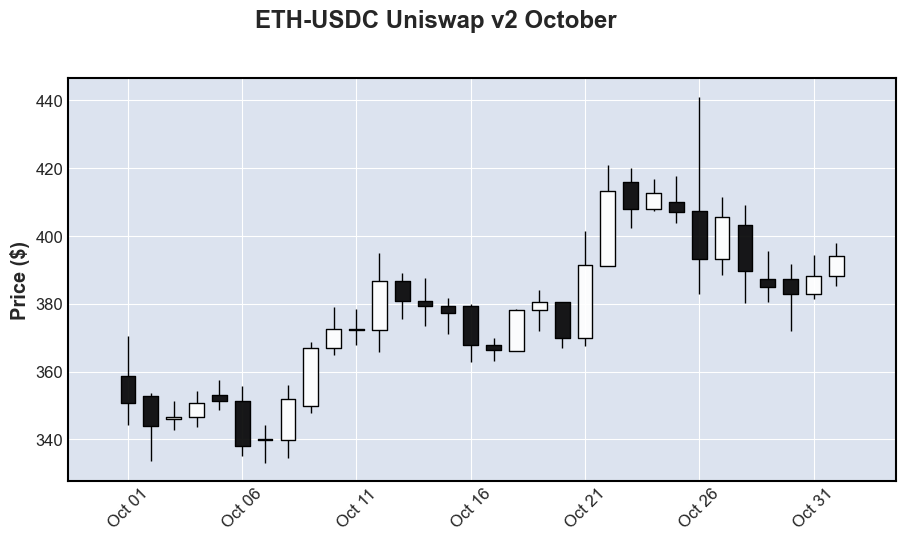

In [5]:
# Our filtering mask for the data
mask = (eth_usdc_pair.timestamp >= "2020-10-1") & (eth_usdc_pair.timestamp <= "2020-11-1")
october = eth_usdc_pair[mask]

# october = eth_usdc_pair.set_index(pd.DatetimeIndex(eth_usdc_pair["timestamp"]))

fplt.plot(
            october,
            type='candle',
            title='ETH-USDC Uniswap v2 October',
            ylabel='Price ($)',
            figratio=(20, 10)
        )



That's all for the basic charts.